# Import libraries

In [2]:
import pandas as pd
import numpy as np
from z3 import *
from itertools import combinations
import itertools
import matplotlib.pyplot as plt
import os
import json
import sys
sys.path.append("../scripts/")
from ControlCost import *
from AttackCost import *
import warnings
warnings.filterwarnings('ignore')

# Current and parent directories

In [3]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

# Accessing Zone-Activity-Appliances Information

In [4]:
zones = pd.read_excel(str(parent_directory) + '/data/Aras-Information.xlsx', sheet_name='Zone-Info')
zone_volume = zones["Volume (cf)"].to_list()                  # Zones' volumes (cubic feet)

energy_appliances = pd.read_excel(str(parent_directory) + '/data/Aras-Information.xlsx', sheet_name='Appliances-Info').iloc[:,-1].to_numpy()
benign_activity_appliances_map = pd.read_excel(str(parent_directory) + '/data/Aras-Information.xlsx', sheet_name='Benign-Activity-Appliances-Map').iloc[:, 4:].to_numpy()

pp_co2 = zones["CO2 Emission by Occupant (cfm)"].to_list()    # CO2 Emission by Occupant (cfm)
pp_heat = zones["Heat Radiation by Occupant (W)"].to_list()   # Heat Radiation by Occupant (W)
load = zones["Heat Radiated by Appliances (W)"].to_list()     # Heat radiated by Appliances (W)

num_zones = len(zones)
num_timeslots = 1440

activities = pd.read_excel(str(parent_directory) + '/data/Aras-Information.xlsx', sheet_name='Activity-Info')
num_activities = len(activities)
activity_zone_map = dict()
for i in range(len(activities)):
    activity_zone_map[int(activities["Activity ID"][i])] = int(activities["Zone ID"][i])

activity_zone_temp_setpoint = [0]
activity_zone_co2_setpoint = [0] 
activity_pp_co2 = [0] + activities['CO2 Emission by Occupant (CFM)'].to_list()    # CO2 Emission by Occupant (cfm)
activity_pp_heat = [0] + activities["Heat Radiation by Occupant (W)"].to_list()   # Heat Radiation by Occupant (W)
activity_load = [0]# Heat radiated by Appliances (W)
activity_zone_volume = [0]

for i in range(1, num_activities + 1):
    activity_zone_temp_setpoint.append(zone_temp_setpoint[activity_zone_map[i]])
    activity_zone_co2_setpoint.append(zone_co2_setpoint[activity_zone_map[i]])
    activity_zone_volume.append(zone_volume[activity_zone_map[i]])
    activity_load.append(sum(benign_activity_appliances_map[i] * energy_appliances))
    
all_samples = list(itertools.permutations([1, 1, 0, 0, 0]))
all_samples += list(itertools.permutations([2, 0, 0, 0, 0]))

unique_samples = set()

for data in all_samples:    
    unique_samples.add(data)

# Convert list to a tuple

In [5]:
def to_tuple(a):
    try:
        return tuple(to_tuple(i) for i in a)
    except TypeError:
        return a

# Fixed parameters

In [6]:
CO2_FRESH_AIR = 400             # CO2 concentration (ppm) of fresh air
TEMP_FRESH_AIR = 91.4           # Temperature (33 degree F) of the fresh air
CP_AIR = 1.026                  # Specific heat of fresh air
DEF_TEMP_SUPPLY_AIR =  55.4     # Default temperature (degree fahrenheit) of supply air (13 degree celsius)

# Control cost calculation

In [7]:
def control_cost (zones, zone_occupant, zone_temp_setpoint, zone_volume, pp_co2, pp_heat, load, zone_co2_setpoint, control_time):
    '''
    PARAMETERS:
    zones: zone information
    zone_occupant: list of occupants in different zones
    zone_temp_setpoint: list of temperature (fahrenheit) setpoint of the different zones
    zone_volume: # Zones' volumes (cubic feet)
    pp_co2: CO2 Emission by Occupant (cfm)
    pp_heat: Heat Radiation by Occupant (W)
    load: Heat radiated by Appliances (W)
    zone_co2_setpoint: list of CO2 (ppm) setpoint of the corresponding zones
    control_time: time of control operation (in minute)
    energy_cost: cost per KWh (USD) at the control time
    '''
    num_zones = len(zones)
    # initializing z3 variables
    v_vent_air = [Real( 'v_vent_air_' + str(i)) for i in range(num_zones)]   # Air required for ventillation (CFM)
    v_temp_air = [Real( 'v_temp_air_' + str(i)) for i in range(num_zones)]   # Air required for cooling (CFM)
    v_mixed_air = [Real( 'v_mixed_air_' + str(i)) for i in range(num_zones)]
    v_fresh_air = [Real( 'v_fresh_air_' + str(i)) for i in range(num_zones)]
    v_return_air = [Real( 'v_return_air_' + str(i)) for i in range(num_zones)]
    zone_cost = [Real( 'zone_cost' + str(i)) for i in range(num_zones)] 
    
    temp_supply_air = [ Real( 'temp_supply_air_' + str(i)) for i in range(num_zones)]
    temp_mixed_air = [ Real( 'temp_mixed_air_' + str(i)) for i in range(num_zones)]
    co2_mixed_air = [ Real( 'co2_mixed_air_' + str(i)) for i in range(num_zones)]
    total_zone_cost = Real('total_zone_cost')

    s = Solver()
    
    for i in range(1, num_zones):
        ############### v_vent_air ###############################
        s.add(zone_occupant[i] * ((pp_co2[i] * 1000000) / zone_volume[i]) == 
                       (zone_co2_setpoint[i] - (( 1 - (v_vent_air[i]) /zone_volume[i]) * zone_co2_setpoint[i] +  
                                                (v_vent_air[i] * CO2_FRESH_AIR) /  zone_volume[i])))
        
        ############### v_temp_air ###############################
        if zone_occupant[i] > 0:
            s.add(v_temp_air[i] *  (zone_temp_setpoint[i] - DEF_TEMP_SUPPLY_AIR) * 0.3167 == zone_occupant[i] * pp_heat[i] + load[i]) 
        else:
            s.add(v_temp_air[i] *  (zone_temp_setpoint[i] - DEF_TEMP_SUPPLY_AIR) * 0.3167 == zone_occupant[i] * pp_heat[i]) 
    
        ############### v_mixed_air ###############################
        s.add(zone_occupant[i] * ((pp_co2[i] * 1000000) / zone_volume[i]) == 
              (zone_co2_setpoint[i] - (( 1 - ( v_mixed_air[i] ) / zone_volume[i]) * zone_co2_setpoint[i] + 
                                     ( v_mixed_air[i] * co2_mixed_air[i]) / zone_volume[i])))
    
        if zone_occupant[i] > 0:
            s.add(v_mixed_air[i] * (zone_temp_setpoint[i] - temp_supply_air[i]) * 0.3167 == zone_occupant[i] * pp_heat[i] + load[i])
        else:
            s.add(v_mixed_air[i] * (zone_temp_setpoint[i] - temp_supply_air[i]) * 0.3167 == zone_occupant[i] * pp_heat[i])

        s.add(v_mixed_air[i] == v_return_air[i] + v_fresh_air[i])
        s.add(co2_mixed_air[i] == zone_co2_setpoint[i] * (v_return_air[i] / v_mixed_air[i]) + CO2_FRESH_AIR * (v_fresh_air[i] / v_mixed_air[i]))
        s.add(temp_mixed_air[i] == zone_temp_setpoint[i] * (v_return_air[i] / v_mixed_air[i]) + TEMP_FRESH_AIR * (v_fresh_air[i] / v_mixed_air[i]))
    
        ############### temperature control algorithm ############
        s.add(Implies(v_vent_air[i] >= v_temp_air[i] , v_return_air[i] == 0))
        s.add(Implies(v_vent_air[i] < v_temp_air[i] ,  temp_supply_air[i] == 55.4))
    
        ############### other constraints ########################
        s.add(v_return_air[i] >= 0)
        s.add(temp_supply_air[i] >= 55.4)
        
        ############## cost constraint ###########################
        s.add(zone_cost[i] == v_mixed_air[i] * (temp_mixed_air[i] - DEF_TEMP_SUPPLY_AIR) * 0.3167 * (control_time / 60000))
    s.add(total_zone_cost == Sum(zone_cost[1:]))
    s.check()
    
    for i in range(1, num_zones):
        v_vent_air[i] = float(Fraction(str(s.model()[v_vent_air[i]])))
        v_temp_air[i] = float(Fraction(str(s.model()[v_temp_air[i]])))
    
        v_mixed_air[i] = float(Fraction(str(s.model()[v_mixed_air[i]])))
        temp_mixed_air[i] = float(Fraction(str(s.model()[temp_mixed_air[i]])))
    
        temp_supply_air[i] = float(Fraction(str(s.model()[temp_supply_air[i]])))
    
        co2_mixed_air[i] = float(Fraction(str(s.model()[co2_mixed_air[i]])))
        v_return_air[i] = float(Fraction(str(s.model()[v_return_air[i]])))
        v_fresh_air[i] = float(Fraction(str(s.model()[v_fresh_air[i]])))
        
        zone_cost[i] = float(Fraction(str(s.model()[zone_cost[i]])))
    total_zone_cost = float(Fraction(str(s.model()[total_zone_cost])))
        
    return total_zone_cost

dict_control_cost = dict()
for sample in unique_samples:
    zone_occupant = list(sample)    
    dict_control_cost[sample] = control_cost(zones, zone_occupant, zone_temp_setpoint, zone_volume, pp_co2, pp_heat, load, zone_co2_setpoint, control_time)

# Zone-wise appliances

In [8]:
zone_appliance = []
zone_appliance.append([1, 2]) #0
zone_appliance.append([11, 16, 17, 23, 27]) #1
zone_appliance.append([12, 13, 18, 22, 25, 26]) #2
zone_appliance.append([3, 4, 5, 6, 7, 8, 9, 10, 19, 24]) #3
zone_appliance.append([14, 15, 20, 21]) #4

# Zone-wise maximum cost for appliances

In [9]:
zone_cost = [0, 0, 0, 0, 0]
for i in range(len(zone_cost)):
    all_costs = []
    for j in range(len(zone_appliance[i])):
        all_costs.append(activity_load[zone_appliance[i][j]])
    zone_cost[i] =  max(all_costs)

# Plotting Function

In [43]:
def plotting(control, without_appliance, with_appliance, plotting_location, plotting_lim, plt_title, saving_directory):
    
    legendlist=['Benign Control Cost', 'Without Appliance Triggering Attack','With Appliance Triggering Attack' ]
    markers=['^','o','s']
    fig= plt.figure(figsize=(8,6.5))
    plt.plot(control, marker = markers[0], linewidth = 3, markersize = 10, color = '#FF3E30', linestyle = '-')
    plt.plot(without_appliance, marker = markers[1], linewidth = 3, markersize = 10, color = '#176BEF', linestyle = '-')
    plt.plot(with_appliance, marker = markers[2], linewidth = 3, markersize = 10, color = '#179C52', linestyle = '-')
    plt.legend(legendlist,loc='upper center',fontsize="20")
    plt.yticks(fontsize="20")
    plt.xticks(fontsize="20")
    plt.ylim(plotting_lim)
    #plt.title(plt_title, fontsize = "16")
    plt.xlabel("Day of the Month",fontsize="24")
    plt.ylabel("Control Cost ($)",fontsize="24")
    plt.grid(True)
    plt.savefig(saving_directory, bbox_inches='tight')

In [44]:
def states_to_schedule(states):
    schedule = np.full(num_timeslots, 0)
    for state in states:
        arrival_time = int(state.split('-')[0])
        arrival_zone = int(state.split('-')[1])
        state_stay_duration = int(state.split('-')[2])
        schedule[arrival_time : arrival_time + state_stay_duration] = arrival_zone
    
    return schedule

# Plotting function (Actual) for a particular house name and adm algo

In [45]:
def plot_house_adm(house_name, adm_algo, plotting_location, plotting_lim, plt_title, saving_directory):
    
    control_costs = pd.read_csv(str(parent_directory) + '\data\\control-costs\\Control-Costs_House-' +str(house_name) +'.csv')['Control Cost ($)'] 
    day_wise_control_costs = []
    for i in range(0, 43200, 1440):
        day_wise_control_costs.append(sum(control_costs[i : i+1400]))


    attack_schedule_1_file = str(parent_directory) + '\data\\attack-schedules\\strength\\Actual_' + str(adm_algo) + '_House-' + str(house_name) + '_Occupant-1.json'
    attack_schedule_2_file = str(parent_directory) + '\data\\attack-schedules\\strength\\Actual_' + str(adm_algo) + '_House-' + str(house_name) + '_Occupant-2.json'

    with open(attack_schedule_1_file, 'r') as file:
        attack_schedule_1 = states_to_schedule(json.load(file)["Longest-Path"])

    with open(attack_schedule_2_file, 'r') as file:
        attack_schedule_2 = states_to_schedule(json.load(file)["Longest-Path"])

    dataframe = pd.read_csv(str(parent_directory) + '\data\\modified\\' + 'Modified-Dataframe_House-' + str(house_name) + '.csv')
    cleaned_dataframe_occ_1 = pd.read_csv(str(parent_directory) + '\data\\cleaned\\' + 'Cleaned-Dataframe_House-' + str(house_name) + '_Occupant-1' + '.csv')
    cleaned_dataframe_occ_2 = pd.read_csv(str(parent_directory) + '\data\\cleaned\\' + 'Cleaned-Dataframe_House-' + str(house_name) + '_Occupant-2' + '.csv')

    processed_dataframe = pd.read_csv(str(parent_directory) + '\data\\processed\\' + 'Processed-Dataframe_House-' + str(house_name) + '.csv')
    
    filename = str(parent_directory) + '\data\\deadlock-elimination\\Actual_' + str(adm_algo) + '_House-' + str(house_name) + '_Occupant-1.json'
    with open(filename, "r") as file:
        data = json.load(file)

    list_time_min_occ_1 = data["List-Time-Min"]
    list_time_max_occ_1 = data["List-Time-Max"]
    
    filename = str(parent_directory) + '\data\\deadlock-elimination\\Actual_' + str(adm_algo) + '_House-' + str(house_name) + '_Occupant-2.json'
    with open(filename, "r") as file:
        data = json.load(file)

    list_time_min_occ_2 = data["List-Time-Min"]
    list_time_max_occ_2 = data["List-Time-Max"]
        
    without_appliances_attack_costs = AttackCost(house_name, dataframe, cleaned_dataframe_occ_1, cleaned_dataframe_occ_2, processed_dataframe, list_time_min_occ_1, list_time_max_occ_1, list_time_min_occ_2, list_time_max_occ_2, attack_schedule_1, attack_schedule_2, dict_control_cost, num_timeslots, num_zones, activity_zone_map, zone_cost).get_attack_costs_without_appliance_triggering()
    with_appliances_attack_costs = AttackCost(house_name, dataframe, cleaned_dataframe_occ_1, cleaned_dataframe_occ_2, processed_dataframe, list_time_min_occ_1, list_time_max_occ_1, list_time_min_occ_2, list_time_max_occ_2, attack_schedule_1, attack_schedule_2, dict_control_cost, num_timeslots, num_zones, activity_zone_map, zone_cost).get_attack_costs_with_appliance_triggering().tolist()

    plotting(day_wise_control_costs, without_appliances_attack_costs, [a + b for a, b in zip(without_appliances_attack_costs, with_appliances_attack_costs)], plotting_location, plotting_lim, plt_title, saving_directory)
    return day_wise_control_costs, without_appliances_attack_costs, with_appliances_attack_costs

# Plotting House A, DBSCAN

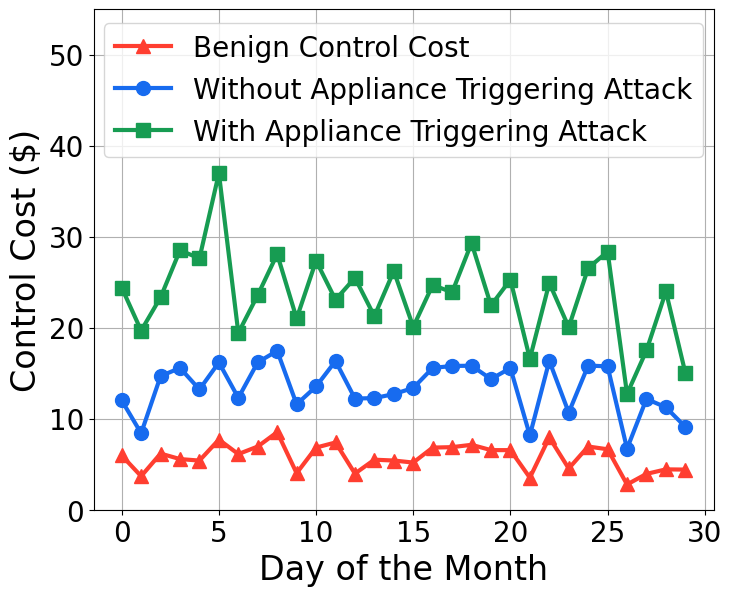

In [47]:
house_name = 'A' 
adm_algo = 'DBSCAN' 
plotting_location = 'upper center'
plt_title = "Evaluation on HA Dataset Trained with DBSCAN ADM"
plotting_lim = [0, 55]
saving_directory = str(parent_directory) + '\plots\\Eval-A_House-A_Full_DBSCAN.pdf' 
day_wise_control_costs, without_appliances_attack_costs, with_appliances_attack_costs = plot_house_adm(house_name, adm_algo, plotting_location, plotting_lim, plt_title, saving_directory)

In [48]:
sum(day_wise_control_costs), sum(without_appliances_attack_costs), sum(without_appliances_attack_costs) + sum(with_appliances_attack_costs)

(173.4244274509422, 401.197512228547, 707.5131523952127)

In [49]:
sum(without_appliances_attack_costs) / sum(day_wise_control_costs), (sum(without_appliances_attack_costs) + sum(with_appliances_attack_costs))/ sum(day_wise_control_costs)

(2.313385248695929, 4.07966261036296)

# Plotting House B, DBSCAN

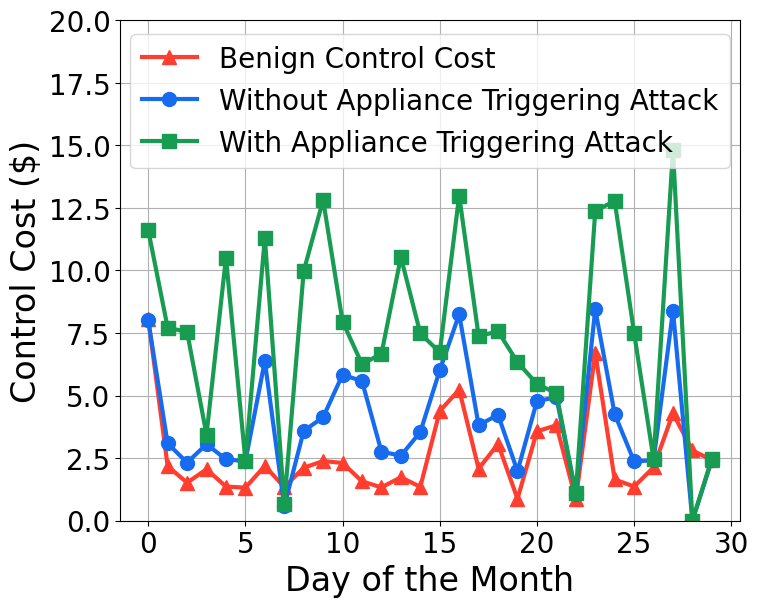

In [50]:
house_name = 'B' 
adm_algo = 'DBSCAN' 
plotting_location = 'upper center'
plt_title = "Evaluation on HA Dataset Trained with DBSCAN ADM"
plotting_lim = [0, 20]
saving_directory = str(parent_directory) + '\plots\\Eval-A_House-A_Full_DBSCAN.pdf' 
day_wise_control_costs, without_appliances_attack_costs, with_appliances_attack_costs = plot_house_adm(house_name, adm_algo, plotting_location, plotting_lim, plt_title, saving_directory)

In [51]:
sum(day_wise_control_costs), sum(without_appliances_attack_costs), sum(without_appliances_attack_costs) + sum(with_appliances_attack_costs)

(78.12815431152166, 119.71530059171678, 221.9655470083849)

In [52]:
sum(without_appliances_attack_costs) / sum(day_wise_control_costs), (sum(without_appliances_attack_costs) + sum(with_appliances_attack_costs))/ sum(day_wise_control_costs)

(1.5322939809172251, 2.841044294011325)